In [28]:
import sys
sys.path.append('../')
from plot_config import *
%matplotlib inline

import numpy as np
def euler_sim(M, x0 ,dt, T, Perturbation=None):
    x = x0
    X = []
    for t in np.linspace(0, T, int(T/dt)):
        if Perturbation is not None:
            x = x + 1j * (M+Perturbation(t)) @ x *dt
        else:
            x = x + 1j*dt*M @ x
        X.append(x)

    return np.array(X, dtype=np.complex128)
def rk4_sim(M, x0, dt, T, Perturbation=None):

    x = x0
    X = []
    for t in np.linspace(0, T, int(T/dt)):
        if Perturbation is not None:
            k1 = 1j * (M+Perturbation(t)) @ x
            k2 = 1j * (M+Perturbation(t+dt/2)) @ (x + k1*dt/2)
            k3 = 1j * (M+Perturbation(t+dt/2)) @ (x + k2*dt/2)
            k4 = 1j * (M+Perturbation(t+dt)) @ (x + k3*dt)
        else:
            k1 = 1j * M @ x
            k2 = 1j * M @ (x + k1*dt/2)
            k3 = 1j * M @ (x + k2*dt/2)
            k4 = 1j * M @ (x + k3*dt)
        x = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6
        X.append(x)

    return np.array(X, dtype=np.complex128)

def implicit_euler_sim(M,x0,dt , T, Perturbation = None):
    x = x0
    X = []
    for t in np.linspace(0, T, int(T/dt)):
        if Perturbation is not None:
            x = np.linalg.solve(np.eye(M.shape[0])-1j*dt*(M+Perturbation(t)), x)
        else:
            x = np.linalg.solve(np.eye(M.shape[0])-1j*dt*M, x)
        X.append(x)


    return np.array(X, dtype=np.complex128)

In [29]:
#constants
from scipy.constants import physical_constants as pc
aut = pc['atomic unit of time'][0]
E = 200*1e-6 / pc['atomic unit of energy'][0] #uJ


tau_p = 5*1e-9 /aut #ns
t_0 = 10*1e-9 /aut #ns
w_0 = 0.5*1e-3 / pc['atomic unit of length'][0] #mm

mu_i_phi = np.sqrt(0.1)*0.15324673 # au
mu_i_psi = np.sqrt(0.2)*0.09692173 #au

E_i_phi = 5000*1e2 * pc["atomic unit of length"][0]  #cm^-1
E_i_psi = 5000*1e2 * pc["atomic unit of length"][0] #cm^-1
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] #cm^-1

#


In [30]:
def intensity(t):
    return 2*E/(tau_p * np.pi* w_0**2)*2**(-4*((t-t_0)/(tau_p))**2)

def Omega_if(t, mu):
    return mu*np.sqrt(intensity(t))

In [31]:
import numpy as np
import matplotlib.pyplot as plt

#plot interactivley



def plot_sim(M, x0, dt, T, algo = euler_sim,  Perturbation=None, plots=None, linestyle='-', pad_strat = 'edge', pad_len = 1e5):
    """
    plot_sim Executes a simulation and plots the results

    Args:
        M (_type_): Propagation matrix
        x0 (_type_): Initial state
        dt (_type_): Time step size
        T (_type_): Total time
        algo (_type_, optional): Alogirthm to run. Defaults to euler_sim.
        Perturbation (_type_, optional): Time dependent perturbation matrix function. Defaults to None.
        plots (_type_, optional): Existing plots to add onto. Defaults to None.
        linestyle (str, optional): linestyle. Defaults to '-'.
        pad_strat (str, optional): padding strategy. Defaults to 'edge'.
        pad_len (_type_, optional): padding length. Defaults to 1e5.

    Returns:
        _type_: _description_
    """
    no_to_state = {
        0: r"i",
        1: r"\varphi",
        2: r"\psi_e"
    }
    if plots is None:
        fig, ax = plt.subplots()
        fig_fft, ax_fft = plt.subplots()
    else:
        fig, ax, fig_fft, ax_fft = plots

    pad_len = int(pad_len)


    X = algo(M, x0, dt, T, Perturbation)
    t = np.linspace(0, T, int(T/dt))


    X = np.pad(X,[(pad_len,pad_len),(0,0)],pad_strat)

    t = np.linspace(-dt*pad_len, T+dt*pad_len, int(T/dt)+ pad_len*2)

    # plot all the states
    for i in range(X.shape[1]):
        ax.plot(t,np.abs(X[:,i]), label=f"$|{no_to_state[i]} \\rangle$ - RK4", linestyle=linestyle)
    ax.legend()

    # plot the fourier transform
    W = np.fft.fft(X, axis=0)
    # move fft
    #W = np.fft.fftshift(W, axes=0)
    # get axis scaling
    freq = np.fft.fftfreq(W.shape[0], d=dt)
    # plot

    W_max = np.max(np.abs(W))
    for i in range(W.shape[1]):
        freq_amplitude = np.abs(W[:,i])
        freq_amplitude = freq_amplitude/W_max

        ax_fft.plot(freq,freq_amplitude, label=f"$|{no_to_state[i]} \\rangle$ - RK4", linestyle=linestyle)

    ax_fft.legend()

    ax_fft.set_xlim((-0.75*1e-7,0.25*1e-7))
    # add axis labels

    ax.set_xlabel("Time $\hbar/E_H$")
    ax.set_ylabel("Population")
    ax_fft.set_xlabel("Frequency ($E_H/\hbar$)")
    ax_fft.set_ylabel("Population arb. u.")

    results = [X,t,W, freq]

    return (fig, ax, fig_fft, ax_fft), results


def compare_algos(M, x0, dt, T, Perturbation=None):
    #plots, results_euler = plot_sim(M, x0, dt, T, euler_sim, Perturbation, linestyle='--')
    plots = None
    _, results_rk4 = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_len=0)
    plt.show()

    #plots, results_rk42 = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=None, linestyle='-.')
    #plt.show()

    results_euler = None #TODO: remove
    return results_euler, results_rk4


#results_euler, results_rk4 = compare_algos(M, np.array([1, 0, 0]), 0.001e-9/aut, 100e-9/aut, laser)


def compare_padding_strats(M,x0,dt,T, Perturbation=None):
    plots = None
    plots_wrap, wrap = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_strat='wrap', pad_len=1e5)
    plots_edge, edge = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_strat='edge', pad_len=1e5)
    plots_zero, zero = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_strat='constant', pad_len=1e5)

    #save the plots
    fig, ax, fig_fft, ax_fft = plots_wrap
    fig.savefig("wrap_td.png")
    fig_fft.savefig("wrap_fd.png")

    fig, ax, fig_fft, ax_fft = plots_edge
    fig.savefig("edge_td.png")
    fig_fft.savefig("edge_fd.png")

    fig, ax, fig_fft, ax_fft = plots_zero
    fig.savefig("zero_td.png")
    fig_fft.savefig("zero_fd.png")

    return

# compare_padding_strats(M, np.array([1, 0, 0]), 0.001e-9/aut, 100e-9/aut, laser)

Simulation for omega = 2.4188843265857e-19 done.
Simulation for omega = 2.689799371163298e-16 done.
Simulation for omega = 5.377179858000012e-16 done.
Simulation for omega = 8.064560344836723e-16 done.
Simulation for omega = 1.0751940831673437e-15 done.
Simulation for omega = 1.343932131851015e-15 done.
Simulation for omega = 1.6126701805346862e-15 done.
Simulation for omega = 1.8814082292183574e-15 done.
Simulation for omega = 2.1501462779020287e-15 done.
Simulation for omega = 2.4188843265857e-15 done.


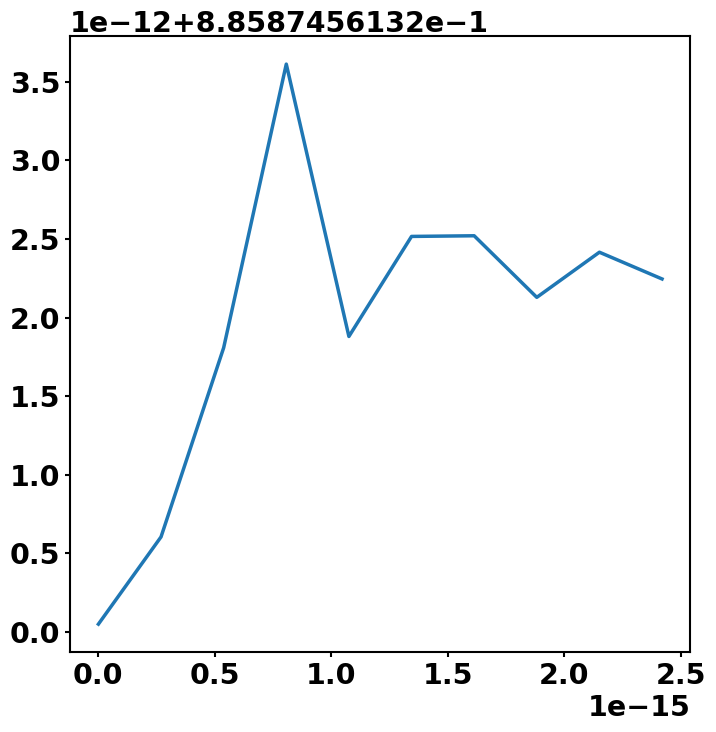

In [32]:


dissoc_yields = []
omega_range = np.linspace(0.01, 100, 10)*aut
for omega in omega_range:
    # omega = aut # s^-1

    E_i = -omega
    E_phi = E_i_phi - omega
    E_psi = E_i_psi - omega + 1j* Gamma_diss/2
    g_phipsi = 0

    #laser
    laser = lambda t: np.array(
        [
            [0, np.conjugate(Omega_if(t,mu_i_phi)), np.conjugate(Omega_if(t,mu_i_psi))],
            [Omega_if(t,mu_i_phi), 0, 0],
            [Omega_if(t,mu_i_psi), 0, 0],
        ]
        )

    M = np.array(
        [
            [E_i, 0,0],
            [0, E_phi, np.conjugate(g_phipsi)],
            [0, g_phipsi, E_psi],
        ]
    )

    x0 = np.array([1, 0, 0])
    dt = 0.001e-9/aut
    T = 60e-9/aut
    Perturbation = laser
    X = rk4_sim(M, x0, dt, T, Perturbation)
    # t = np.linspace(0, T, int(T/dt))

    dissoc_yields.append(np.abs(X[-1,0])**2)
    print(f'Simulation for omega = {omega} done.')


plt.plot(omega_range, dissoc_yields)
plt.show()



In [33]:
# plotly interactive plots
import plotly.express as px
import pandas as pd

#show interactiveley
X,t, W, f =results_rk4
if len(t) <= 10000:

    X = np.real(X)
    W = np.real(W)

    # timd domain
    df_t = pd.DataFrame(X,t)
    df_f = pd.DataFrame(W,f)

    fig_t = px.line(df_t)
    fig_f = px.line(df_f)

    fig_t.show()
    fig_f.show()
else:
    print('skipped interactive plotting due to too much data')

NameError: name 'results_rk4' is not defined